# Code Snippet 1: Downloading and Plotting Raw Seismic Data

In [1]:
pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.40
    Uninstalling SQLAlchemy-2.0.40:
      Successfully uninstalled SQLAlchemy-2.0.40
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


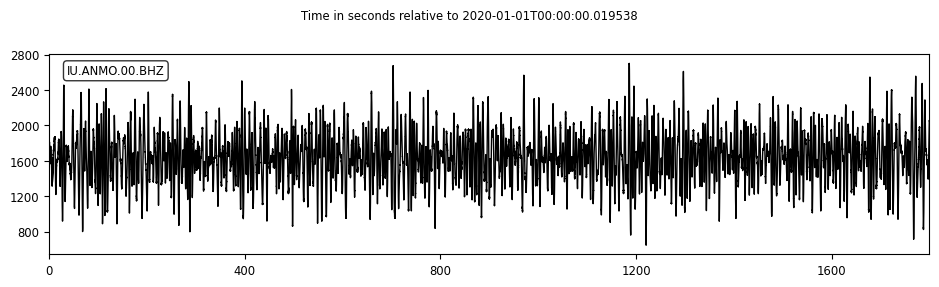

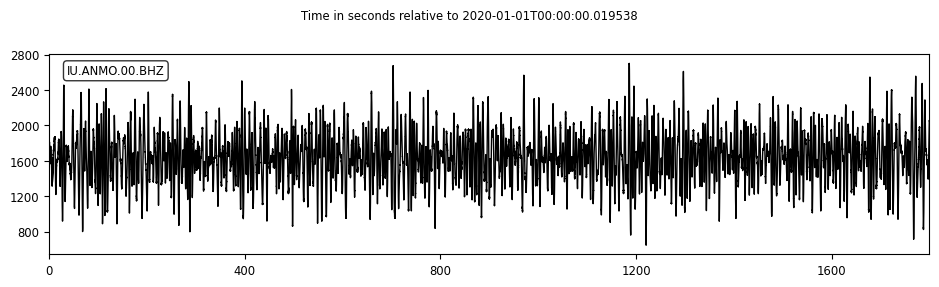

In [12]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt

# Initialize IRIS FDSN client
client = Client("IRIS")

# Define time range and station parameters
starttime = UTCDateTime("2020-01-01T00:00:00")
endtime = UTCDateTime("2020-01-01T00:30:00")
network = "IU"
station = "ANMO"
location = "00"
channel = "BHZ"

# Request waveform data
st = client.get_waveforms(network, station, location, channel, starttime, endtime)

# Plot the time-domain waveform
st.plot(type="relative", title="Raw Seismic Signal from IU.ANMO.BHZ", size=(1000, 300))


# Computing FFT of Raw Signal

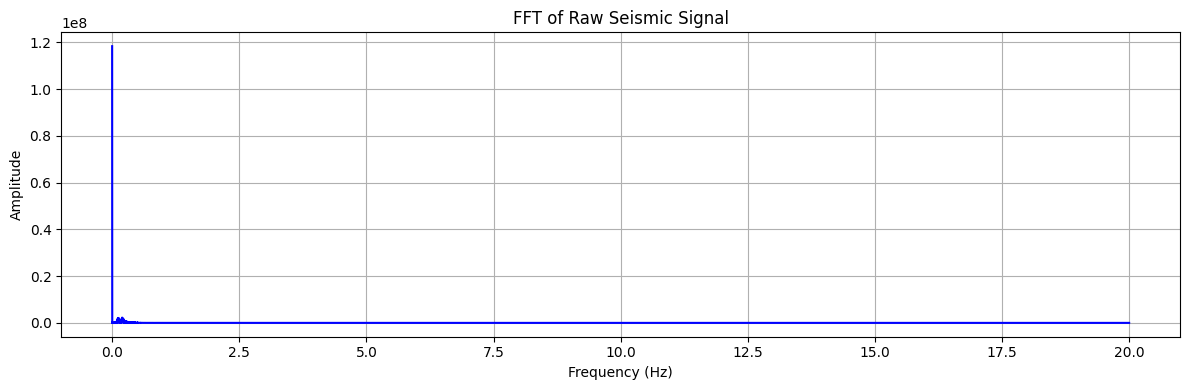

In [11]:
import numpy as np
# Extract the Trace object (tr) from the Stream (st)
tr = st[0]

#print(st)
# Compute the FFT of the raw signal
signal = tr.data # signal data
sampling_rate = tr.stats.sampling_rate # sampling rate of data
n = len(signal)

# Compute FFT and frequency bins
fft_result = np.fft.fft(signal) # using fft function
frequencies = np.fft.fftfreq(n, d=1/sampling_rate) # frequency bins of fft
magnitude = np.abs(fft_result)

# Plot the fft
plt.figure(figsize=(12, 4))
plt.plot(frequencies[:n // 2], magnitude[:n // 2], color='blue')
plt.title("FFT of Raw Seismic Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# cleaning data

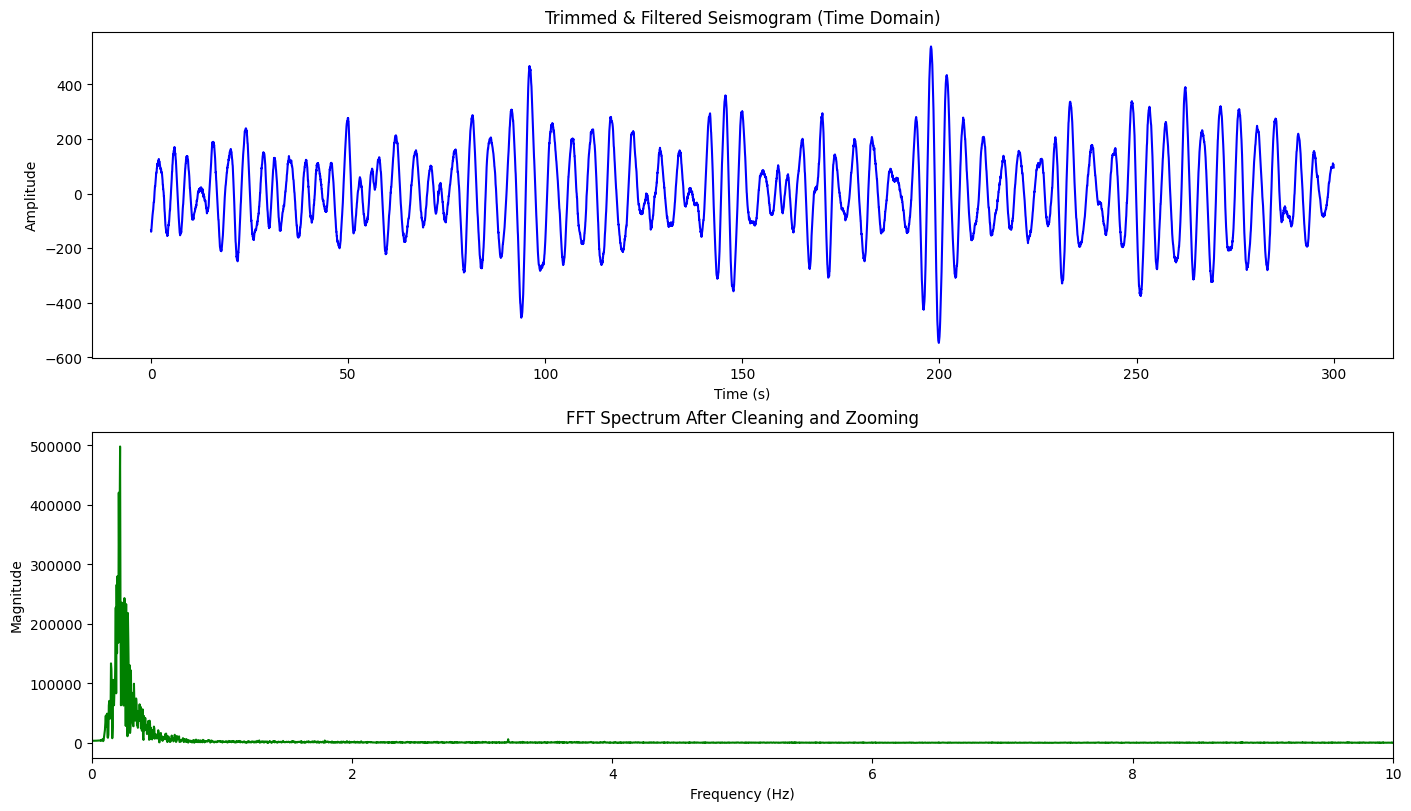

In [13]:
from obspy.signal.filter import bandpass

tr = st[0]

# Preprocessing to reveal more detail
tr.detrend("linear")                  # Remove trends
tr.taper(max_percentage=0.05)        # Smooth edges
# Bandpass filter to take away 0 Hz and much higher frequencies
tr.filter("bandpass", freqmin=0.2, freqmax=10.0)

# Zoom into active region (e.g. 5 to 10 minutes into trace)
tr.trim(starttime + 300, starttime + 600)

# Extract signal and sampling info
signal = tr.data
sampling_rate = tr.stats.sampling_rate
n = len(signal)
time = np.linspace(0, n / sampling_rate, n)

# FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
magnitude = np.abs(fft_result)

# Plot time and frequency domain
fig, axs = plt.subplots(2, 1, figsize=(14, 8), constrained_layout=True)

# Time-domain plot
axs[0].plot(time, signal, color='blue')
axs[0].set_title("Trimmed & Filtered Seismogram (Time Domain)")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# Frequency-domain plot (zoomed in)
# We can see the bandpass filter worked
axs[1].plot(frequencies[:n//2], magnitude[:n//2], color='green')
axs[1].set_xlim(0, 10)  # Zoom into most relevant frequencies
axs[1].set_title("FFT Spectrum After Cleaning and Zooming")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")

plt.show()

# Scalogram
Make sure that if you want to run this code, you run the first code block again every time to get the signal. The preprocessing edits 'tr' every time so the preprocessing done above actually makes the data have worse resolution as you do the preprocessing multiple times.


In [8]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.0 MB/s eta 0:00:00


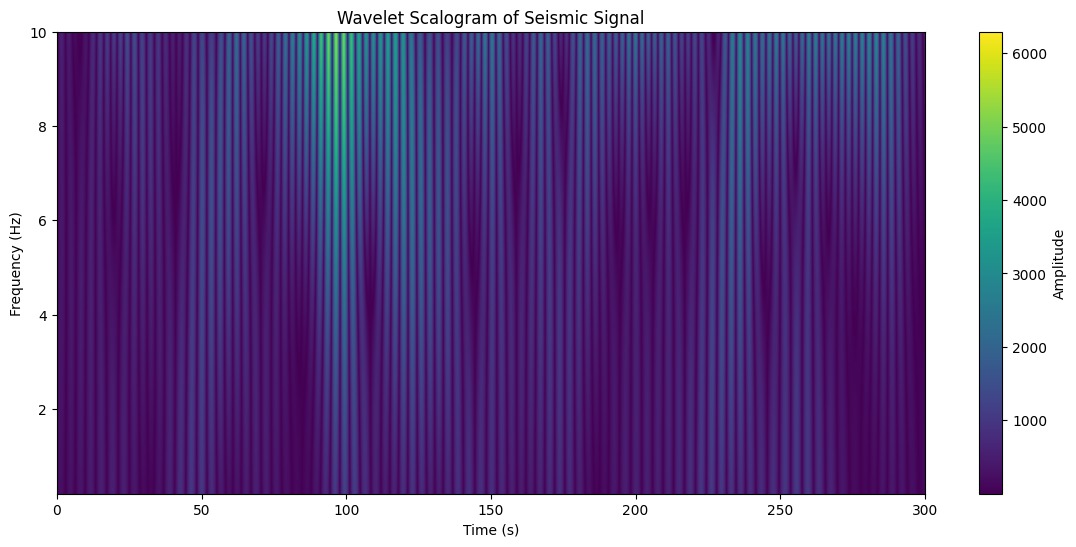

In [9]:

import pywt

#same thing as before
tr = st[0]

# Preprocessing
tr.detrend("linear")
tr.taper(max_percentage=0.05)
tr.filter("bandpass", freqmin=0.2, freqmax=10.0)
tr.trim(starttime + 300, starttime + 600)

signal = tr.data
sampling_rate = tr.stats.sampling_rate
time = np.linspace(0, len(signal) / sampling_rate, num=len(signal))

# Apply Continuous Wavelet transform
scales = np.arange(1, 256)
coefficients, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/sampling_rate)

# Plot the Scalogram
plt.figure(figsize=(14, 6))
plt.imshow(np.abs(coefficients), extent=[time[0], time[-1], freqs[-1], freqs[0]],
           cmap='viridis', aspect='auto', interpolation='bilinear')
plt.colorbar(label='Amplitude')
plt.title("Wavelet Scalogram of Seismic Signal")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.ylim(0.2, 10)  # Focus on relevant frequency range
plt.show()